In [1]:
import tensorflow as tf
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, TimeDistributed, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from typing import List
import os

In [2]:
# Define character set
character_set = [x for x in "abcdefghijklmnopqrstuvwxyz123456789'?! "]

In [3]:
# Convert character to number: 'a' = 1, 'b' = 2, ..., 'z' = 26
char_to_num = tf.keras.layers.StringLookup(vocabulary=character_set, oov_token="")

In [4]:
# Convert number to character: 1 = 'a', 2 = 'b', ..., 26 = 'z'
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

In [5]:
# Return frames and annotation of the video
def load_frames_and_annotation(path): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('data','videos',f'{file_name}.mpg')
    annotation_path = os.path.join('data','annotations',f'{file_name}.align')
    # Get normalized frames of the video
    cap = cv2.VideoCapture(video_path)
    frames = []
    for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[210:256,115:255,:])
    cap.release()
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    frames = tf.cast((frames - mean), tf.float32) / std
    # Get annotation of the video
    with open(annotation_path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    annotation = char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]
    return frames, annotation

In [6]:
# Test Preprocessing
sample_path = './data/videos/bbae2n.mpg'
tf.convert_to_tensor(sample_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]
frames, annotation = load_frames_and_annotation(tf.convert_to_tensor(sample_path))

In [7]:
# (Number of frames, Height of each frame, Width of each frame)
frames.shape

TensorShape([75, 46, 140, 1])

In [8]:
annotation

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  5, 39, 20, 23, 15,
       39, 14, 15, 23])>

In [9]:
# Decoded annotation
tf.strings.reduce_join([num_to_char(word) for word in annotation])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at e two now'>

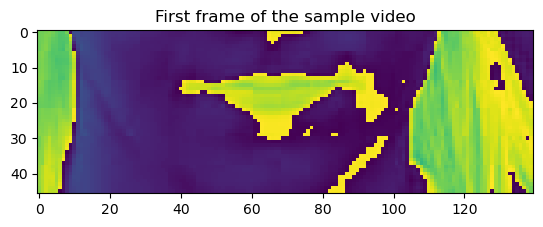

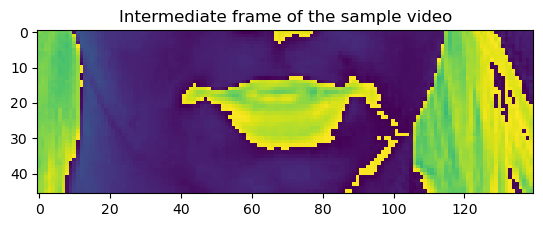

In [10]:
# Frames of the sample video
plt.imshow(frames[0])
plt.title("First frame of the sample video")
plt.show()
plt.imshow(frames[28])
plt.title("Intermediate frame of the sample video")
plt.show()

In [11]:
# Allow to work with specific file formats
def wrap_function(path):
    return tf.py_function(load_frames_and_annotation, [path], (tf.float32, tf.int64))

In [12]:
# Build data pipeline
data = tf.data.Dataset.list_files('./data/videos/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(wrap_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data_size = data.reduce(tf.constant(0), lambda x, _: tf.add(x, 1)).numpy()
train_size = int(0.8 * data_size)
test_size = data_size - train_size
train_data = data.take(train_size)
test_data = data.skip(train_size)

[mpeg1video @ 0x1693c9000] ac-tex damaged at 22 17
[mpeg1video @ 0x1693c9000] Warning MVs not available
[mpeg1video @ 0x1394a4400] ac-tex damaged at 22 17
[mpeg1video @ 0x1394a4400] Warning MVs not available
[mpeg1video @ 0x1693c9000] ac-tex damaged at 22 17
[mpeg1video @ 0x1693c9000] Warning MVs not available


In [13]:
# Test data pipeline
frames, annotation = data.as_numpy_iterator().next()

In [14]:
# Number of frames
len(frames)

2

In [15]:
# Length of each frame
len(frames[0])

75

In [16]:
annotation

array([[16, 12,  1,  3,  5, 39, 18,  5,  4, 39, 23,  9, 20,  8, 39, 10,
        39, 26,  5, 18, 15, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  9, 14, 39, 23,  8,  9, 20,  5, 39,  9, 14, 39, 12, 39,  6,
         9, 22,  5, 39, 19, 15, 15, 14,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [17]:
model = Sequential()
model.add(Conv3D(128, 3, activation='relu', padding='same', input_shape=(75,46,140,1)))
model.add(MaxPool3D((1,2,2)))
model.add(Conv3D(256, 3, activation='relu', padding='same'))
model.add(MaxPool3D((1,2,2)))
model.add(Conv3D(75, 3, activation='relu', padding='same'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(0.5))
model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [18]:
model.input_shape

(None, 75, 46, 140, 1)

In [19]:
model.output_shape

(None, 75, 41)

In [20]:
def learning_rate_scheduler(epoch, lr):
    if epoch < 25:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [21]:
# Credit to https://keras.io/examples/audio/ctc_asr/#model
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [22]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [23]:
model_schedule_callback = LearningRateScheduler(learning_rate_scheduler)
checkpoint_file_path = os.path.join('model','checkpoint')
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_file_path, monitor='loss', save_weights_only=True) 

In [ ]:
# Model has been trained and its checkpoints have been saved in model directory
model.fit(train_data, validation_data=test_data, epochs=65, callbacks=[model_schedule_callback, model_checkpoint_callback])

In [24]:
model.load_weights('model/checkpoint')

In [ ]:
sample = test_data.as_numpy_iterator().next()

[mpeg1video @ 0x139541800] ac-tex damaged at 22 17
[mpeg1video @ 0x139541800] Warning MVs not available
[mpeg1video @ 0x2c10c1a00] ac-tex damaged at 22 17
[mpeg1video @ 0x2c10c1a00] Warning MVs not available


In [26]:
prediction = model.predict(sample[0])

1/1 [==============================] - 2s 2s/step


In [27]:
# Actual text of sample video
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

[<tf.Tensor: shape=(), dtype=string, numpy=b'place white with d zero now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set red with u sp one soon'>]

In [28]:
# Predicted text of sample video
decoded = tf.keras.backend.ctc_decode(prediction, input_length=[75,75], greedy=True)[0][0].numpy()
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

[<tf.Tensor: shape=(), dtype=string, numpy=b'place white wit zer now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set red with one soon'>]